In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
 
from mlprecip_utils import *
from mlprecip_models import *
from mlprecip_datasets import *
from mlprecip_xai import *
from mlprecip_plot import *

import mlprecip_datasets

import warnings

Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

In [2]:
warnings.filterwarnings("ignore")

### Set Some Variables

In [3]:
varname='precip'
#model_types=['logmodel_med'] #,'nnmodel_med']
model_types=['nnmodel_med']
winter=[12,1,2]
summer=[6,7,8]
nmodels=100

#target_dataset='era5-precip'
target_dataset='era-interim-precip'

### Read in Target and Features for Training and Validation

In [4]:
ds_features_tval=xr.open_dataset('../data/fnn/features_trainval.nc')
ds_target_tval=xr.open_dataset('../data/fnn/'+target_dataset+'/target_trainval.nc')

In [5]:
indices_dict=init_predictors_dict()

### Main Program

Winter
nnmodel_med
<xarray.Dataset>
Dimensions:          (time: 3429, RMM_phase_bins: 9, nash_phase_bins: 4, pnaregimes_bins: 5)
Coordinates:
  * time             (time) datetime64[ns] 1979-01-02 1979-01-03 ... 2016-12-31
  * RMM_phase_bins   (RMM_phase_bins) int64 0 1 2 3 4 5 6 7 8
  * nash_phase_bins  (nash_phase_bins) int64 0 1 2 3
  * pnaregimes_bins  (pnaregimes_bins) int64 0 1 2 3 4
Data variables:
    amo              (time) float64 -1.082 -1.083 -1.085 ... 1.219 1.202 1.185
    nao              (time) float64 -2.066 -2.086 -2.107 ... 0.2087 0.1981
    nino34           (time) float64 -0.08613 -0.08872 ... -0.5052 -0.5026
    pdo              (time) float64 -0.8011 -0.8058 -0.8104 ... 0.6352 0.6228
    RMM_amp          (time) float64 0.1807 0.4204 0.305 ... -1.628 -0.7802
    RMM_phase        (time) float64 6.0 6.0 6.0 6.0 6.0 ... 4.0 4.0 6.0 2.0 2.0
    mlso             (time) float64 0.2961 0.3399 0.3879 ... 0.1418 0.1087
    nash_phase       (time) float64 0.0 0.0 0.0 0.0 0.0 

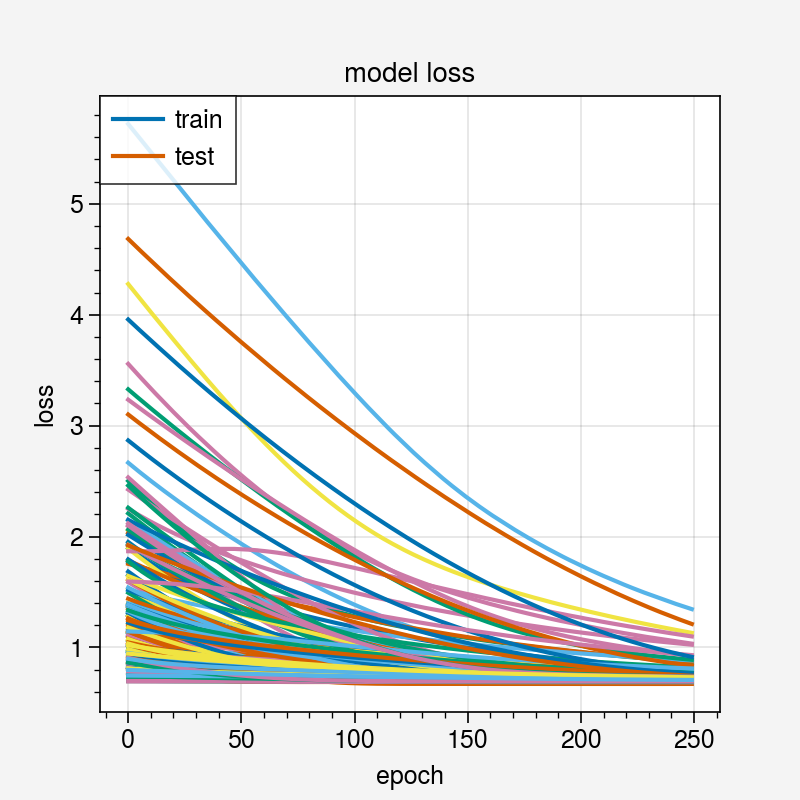

In [6]:
# Loop over seasons
#for seas,slabel,seas_abbrv in zip([winter,summer],['Winter','Summer'],['DJF','JJA']):
for seas,slabel,seas_abbrv in zip([winter],['Winter'],['DJF']):

    print(slabel)
    
    # Get list of predictors for this season
    pred_list=[]
    for d in indices_dict:
        if seas_abbrv in d['seas']:
            pred_list.append(d['name'])
    
    # Select season from target precip anomalies
    ds_t=ds_target_tval.sel(time=ds_target_tval['time.month'].isin(seas))
    ds_f=ds_features_tval.sel(time=ds_features_tval['time.month'].isin(seas))
    
    # Make sure we have the same times for target and features
    ds_t,ds_f=xr.align(ds_t,ds_f.fillna(0.0),join='inner')
    
    # Subtract the median to ensure data is centered and classes are equal
    median=np.percentile(ds_t[varname],50)
    ds_t[varname]=ds_t[varname]-median
    
    # Call Function to train models
    for m_function in model_types:
        print(m_function)
        fname='../data/fnn/'+target_dataset+'/models/seus.median.'+seas_abbrv+'.'+m_function
        ofname='../data/fnn/'+target_dataset+'/output/model_output.'+seas_abbrv+'.'+m_function
        trainIndexModels(m_function,ds_f,ds_t,
                         varname,nmodels,fname=fname,ofname=ofname)